# Searching for solutions

CSI4106 Artificial Intelligence  
Fall 2018  
Caroline Barrière

We will look at the implementation of a search space.  The code below is largely inspired from the resources provided with the book Artificial Intelligence, Foundations of Computational Agents (https://artint.info/2e/online.html).  The resources corresponding to Chapter 3, on Searching for Solutions, are found here https://artint.info/AIPython/.  

There is even a companion Python book, with explanation of all the python code accompanying the book, as well as a first chapter called **Python for AI** where they give some basics of Python.  See https://artint.info/AIPython/aipython.pdf

The code below is more specifically based on the code in the file *searchProblem.py*.  You do not need to go back to that code. Everything you need is specified in the notebook.  I have modified the original code, and I'm presenting it here in small chunks so as to allow students less familiar with python to go through slowly. 

***HOMEWORK***:  
Go through the notebook by running each cell, one at a time.  
Look for **(TO DO)** for the tasks that you need to perform.  Once you're done, submit your notebook.  
***

**1. Definition of a directed graph.**  
A directed graph is made of nodes and arcs.  The class below defines an arc that connects two nodes.  The first two parameters give the two connected nodes.  The other two parameters provide optional cost of an arc (with default to 1) and an optional action of the arc (default to None).  The *init* is the constructor.  The *assert* states a condition that must be true and provides what to do otherwise.

In [2]:
class Arc(object):
    """An arc has a from_node and a to_node node and a (non-negative) cost"""
    
    def __init__(self, from_node, to_node, cost=1, action=None):
        assert cost >= 0, ("Cost cannot be negative for"+
                           str(from_node)+"->"+str(to_node)+", cost: "+str(cost))
        self.from_node = from_node
        self.to_node = to_node
        self.action = action
        self.cost=cost

    def __repr__(self):
        """string representation of an arc"""
        if self.action:
            return str(self.from_node)+" --"+str(self.action)+"--> "+str(self.to_node)
        else:
            return str(self.from_node)+" --> "+str(self.to_node)

Here is an example of a small DAG (Directed Acyclic Graph).
        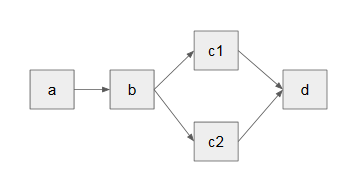

Let's construct a DAG using the Arc class defined above.

In [3]:
# Defining a small dag
dag1 = [Arc('a','b'), Arc('b','c1'), Arc('c1','d'), Arc('b','c2'), Arc('c2','d')]

In [4]:
# print the dag
print(dag1)

[a --> b, b --> c1, c1 --> d, b --> c2, c2 --> d]


The Node class is not defined.  So far, it is assumed that a Node will simply be a string.

**2. Search Space **  
Instead of describing a dag as simply a set of arcs, we can more formally define a class that will represent a search problem which will contain not only the list of arcs, but the explicit list of nodes, the actual start node and the goals.  This class also contains useful methods to "query" the search problem for a node's neighbors, or for determining if a node is a goal or not. It also allows to include a heuristic function, which we will use later.

In [5]:
class Search_problem_from_explicit_graph():
    """A search problem consists of:
    * a list or set of nodes
    * a list or set of arcs
    * a start node
    * a list or set of goal nodes
    * a dictionary that maps each node into its heuristic value.
    """

    def __init__(self, nodes, arcs, start=None, goals=set(), hmap={}):
        self.neighs = {}
        self.nodes = nodes
        for node in nodes:
            self.neighs[node]=[]
        self.arcs = arcs
        for arc in arcs:
            self.neighs[arc.from_node].append(arc)
        self.start = start
        self.goals = goals
        self.hmap = hmap

    def start_node(self):
        """returns start node"""
        return self.start
    
    def is_goal(self,node):
        """is True if node is a goal"""
        return node in self.goals

    def neighbors(self,node):
        """returns the neighbors of node"""
        return self.neighs[node]

    def heuristic(self,node):
        """Gives the heuristic value of node n.
        Returns 0 if not overridden in the hmap."""
        if node in self.hmap:
            return self.hmap[node]
        else:
            return 0
        
    def __repr__(self):
        """returns a string representation of the search problem"""
        res=""
        for arc in self.arcs:
            res += str(arc)+".  "
        return res

    def neighbor_nodes(self,node):
        """returns an iterator over the neighbors of node"""
        return (path.to_node for path in self.neighs[node])


Below is an example of a search problem that we might want to represent. Assuming we wish to go from node 'a' to 'f' (highlighted in yellow).  Under the figure is the definition.

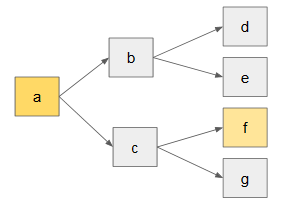

In [6]:
# Defining a search space
problemSimple = Search_problem_from_explicit_graph(
    {'a','b','c','d','e', 'f', 'g'},
    [Arc('a','b',1), Arc('a','c',1), Arc('b','d',1), Arc('b','e',1),
        Arc('c','f',1), Arc('c','g',1)],
    start = 'a',
    goals = {'f'})

In [7]:
# Print some informations
print(problemSimple.neighbors('a'))

[a --> b, a --> c]


**(TO DO)** Print the start node. Test if node 'e' is a goal node.  Go through the list of nodes to find which one is the goal.

In [8]:
# Print the start node. 
print(problemSimple.start)
# Test if node 'e' is a goal node. 
print(problemSimple.is_goal('e'))
# Go through the list of nodes to find which one is the goal.
print(problemSimple.goals)


a
False
{'f'}


**(TO DO)** Complete the definition of the problem space below, according to the following DAG.  The cost are not all equal to 1 now, but are rather given on the arcs.

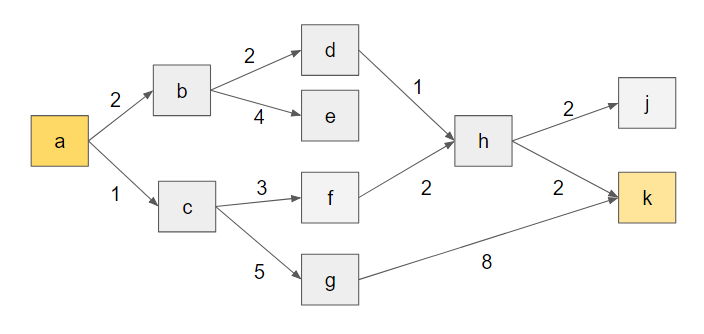

In [9]:
problemTest = Search_problem_from_explicit_graph(
    {'a','b','c','d','e', 'f', 'g', 'h', 'j', 'k'},
    [Arc('a','b',2), Arc('a','c',1), Arc('b','d',2), Arc('b','e',4),
        Arc('c','f',3), Arc('c','g',5),
        Arc('d','h',1), Arc('f','h',2), Arc('g','k',8),
        Arc('h','j',2), Arc('h','k',2)],
    start = 'a',
    goals = {'k'})



**3. Definition of a solution as a path.**  
A solution to a search problem is usually a Path, providing the set of visited nodes and arcs from source node to goal node.  Below a path is defined as either a single node (when arc=None), or a path followed by an arc.  Do not worry too much about all the implementation details in this class.  As your python skills get better, it will become more clear.

In [10]:
# class to represent a path
class Path(object):
    """A path is either a node or a path followed by an arc"""
    
    def __init__(self,initial,arc=None):
        """initial is either a node (in which case arc is None) or
        a path (in which case arc is an object of type Arc)"""
        self.initial = initial
        self.arc=arc
        if arc is None:
            self.cost=0
        else:
            self.cost = initial.cost+arc.cost

    def end(self):
        """returns the node at the end of the path"""
        if self.arc is None:
            return self.initial
        else:
            return self.arc.to_node

    def nodes(self):
        """enumerates the nodes for the path.
        This starts at the end and enumerates nodes in the path backwards."""
        current = self
        while current.arc is not None:
            yield current.arc.to_node
            current = current.initial
        yield current.initial

    def initial_nodes(self):
        """enumerates the nodes for the path before the end node.
        This starts at the end and enumerates nodes in the path backwards."""
        if self.arc is not None:
            for nd in self.initial.nodes(): yield nd     # could be "yield from"
        
    def __repr__(self):
        """returns a string representation of a path"""
        if self.arc is None:
            return str(self.initial)
        elif self.arc.action:
            return (str(self.initial)+"\n   --"+str(self.arc.action)
                    +"--> "+str(self.arc.to_node))
        else:
            return str(self.initial)+" --> "+str(self.arc.to_node)

**4.  Definition of a generic searcher**  
We first define a class representing a generic searcher, but with no strategy as to which node will be explored next. 

In [11]:
# (CB) modified from book
class GenericSearcher():
    """returns a searcher for a problem.
    Paths can be found by repeatedly calling search().
    This does depth-first search unless overridden
    """
    def __init__(self, problem):
        """creates a searcher from a problem
        """
        self.problem = problem
        self.initialize_frontier()

    def initialize_frontier(self):
        self.frontier = [Path(self.problem.start_node())]
        
    def empty_frontier(self):
        return self.frontier == []
       
    ### change the add_to_frontier method --- THIS METHOD NEEDS TO BE IMPLEMENTED FOR DIFFERENT SEARCH STRATEGIES
    def add_to_frontier(self,path):
        raise NotImplementedError
        
    def search(self):
        """returns (next) path from the problem's start node
        to a goal node. 
        Returns None if no path exists.
        """
        while not self.empty_frontier():
            # HERE -- The next node explored is selected
            # It is implemented with a Pop, which actually removes from the end of the list
            path = self.frontier.pop()            
            print(path)
            if self.problem.is_goal(path.end()):    # solution found
                self.solution = path                # store the solution found
                return path
            else:
                neighs = self.problem.neighbors(path.end())              
                for arc in neighs:
                    self.add_to_frontier(Path(path,arc))              

**5. Let's implement the three blind searchers.**  
As we saw in class, the behavior of a searcher depends on how the frontier is dealt with.  We refine the generic searcher into three specific searchers.  The three blind searchers we implement are depth-first, breadth-first and lowest-cost.  The breadth-first is implemented below.  You are asked to implement the other two.

In [12]:
# (CB) extend the generic searcher to be a Breadth-first searcher.
class BreadthFirstSearcher(GenericSearcher):
    
    def __init__(self, problem):   
        super().__init__(problem)

    def add_to_frontier(self,path):
        # breadth
        self.frontier.insert(0,path)        # HERE, I insert in position 0, knowing that I want a FIFO

In [13]:
# Test breadth-first searcher
searcherBreadth = BreadthFirstSearcher(problemTest)  
print("Exploring nodes:")
foundPath = searcherBreadth.search();
print('Path found: {} with a cost of {}'.format(foundPath, foundPath.cost))

Exploring nodes:
a
a --> b
a --> c
a --> b --> d
a --> b --> e
a --> c --> f
a --> c --> g
a --> b --> d --> h
a --> c --> f --> h
a --> c --> g --> k
Path found: a --> c --> g --> k with a cost of 14


**(TO DO)** Implement the add_fo_frontier method for the depth-first search.  And test your implementation.

In [14]:
# Depth-first searcher
class DepthFirstSearcher(GenericSearcher):
    def __init__(self, problem):   
        super().__init__(problem)

    def add_to_frontier(self,path):
        # depth - put code here
        self.frontier.append(path ) 

In [15]:
# Test
searcherDepth = DepthFirstSearcher(problemTest)  
print("Exploring nodes:")
foundPath = searcherDepth.search();
print('Path found: {} with a cost of {}'.format(foundPath, foundPath.cost))

Exploring nodes:
a
a --> c
a --> c --> g
a --> c --> g --> k
Path found: a --> c --> g --> k with a cost of 14


**(TO DO)** Implement the add_fo_frontier method for the lowest-cost search. And test your implementation.

In [22]:
# Lowest Cost searcher
class LowCostSearcher(GenericSearcher):
    def __init__(self, problem):   
        super().__init__(problem)

    def add_to_frontier(self,path):
        # add path to the frontier 
        self.frontier.insert(0,path)
        # gather all the costs of all paths in hvalues
        hvalues = [p.cost for p in self.frontier]
        # find the position of the minimum cost
        posMin = hvalues.index(min(hvalues))
        # remove the element at the position found and append it to the list, so that "pop" finds it there later
        self.frontier.append(self.frontier.pop(posMin))
        
     

In [23]:
# Test
searcherLowCost = LowCostSearcher(problemTest)  
print("Exploring nodes:")
foundPath = searcherLowCost.search();
print('Path found: {} with a cost of {}'.format(foundPath, foundPath.cost))

Exploring nodes:
a
a --> c
a --> b
a --> c --> f
a --> b --> d
a --> b --> d --> h
a --> b --> e
a --> c --> f --> h
a --> c --> g
a --> b --> d --> h --> k
Path found: a --> b --> d --> h --> k with a cost of 7


**6. Heuristic searches**  
We have seen three types of heuristic searches in class: greedy, best-first and A*.  We can implement them, as different specific searchers which will modify the add_to_frontier method of the generic searcher.

Let's assume the heuristic function provides an optimistic distance of each node to the goal node 'k'. These distances are encoded in a dictionary call hmap, in the problem definition below, which is an extension to problemTest defined earlier.

In [18]:
problemTestWithHeuristics = Search_problem_from_explicit_graph(
    {'a','b','c','d','e', 'f', 'g', 'h', 'j', 'k'},
    [Arc('a','b',2), Arc('a','c',1), Arc('b','d',2), Arc('b','e',4),
     Arc('c','f',3), Arc('c','g',5), Arc('d', 'h', 1), Arc('f','h',2),
     Arc('h', 'j',2), Arc('h','k',2), Arc('g','k',8)],
    start = 'a',
    goals = {'k'},
     hmap = {'a':10, 'b':8, 'c':6, 'd':5, 'e':6, 'f':4, 'g':4, 'h':2, 'j':2, 'k':0})

Here is an implementation of the A* searcher.

In [19]:
class AStarSearcher(GenericSearcher):
    """returns a searcher for a problem.
    Paths can be found by repeatedly calling search().
    """

    def __init__(self, problem):   
        super().__init__(problem)

    def add_to_frontier(self,path):
        """add path to the frontier with the appropriate cost"""
        # add path to the frontier 
        self.frontier.append(path)
        # gather all the costs of all paths in hvalues
        hvalues = [p.cost+self.problem.heuristic(path.end()) for p in self.frontier]
        # find the position of the minimum cost
        posMin = hvalues.index(min(hvalues))
        # remove the element at the position found and append it to the list, so that "pop" finds it there later
        self.frontier.append(self.frontier.pop(posMin))  # put it in front for pop to work later

In [20]:
# Test
searcherAStar = AStarSearcher(problemTestWithHeuristics)  
print("Exploring nodes:")
foundPath = searcherAStar.search();
print('Path found: {} with a cost of {}'.format(foundPath, foundPath.cost))

Exploring nodes:
a
a --> c
a --> b
a --> b --> d
a --> c --> f
a --> b --> d --> h
a --> b --> e
a --> b --> d --> h --> k
Path found: a --> b --> d --> h --> k with a cost of 7


**(TO DO**) The A* searcher is implemented above.  Inspired from it, implement the best-first searcher, and test it.

In [35]:
# Best first searcher
class BestFirstSearcher(GenericSearcher):
    """returns a BestFirstSearcher for a problem.
    Paths can be found by repeatedly calling search().
    """

    def __init__(self, problem):   
        super().__init__(problem)

    def add_to_frontier(self,path):
        """add path to the frontier with the appropriate cost"""
        # add path to the frontier 
        #self.frontier.append(path)
        self.frontier.insert(0,path)
        # gather all the costs of all paths in hvalues
        hvalues = [self.problem.heuristic(path.end()) for p in self.frontier]
        # find the position of the minimum cost
        posMin = hvalues.index(min(hvalues))
        # remove the element at the position found and append it to the list, so that "pop" finds it there later
        self.frontier.append(self.frontier.pop(posMin))  

In [36]:
# Test
searcherBestFirstSearcher = BestFirstSearcher(problemTestWithHeuristics)  
print("Exploring nodes:")
foundPath = searcherBestFirstSearcher.search();
print('Path found: {} with a cost of {}'.format(foundPath, foundPath.cost))

Exploring nodes:
a
a --> c
a --> c --> g
a --> c --> g --> k
Path found: a --> c --> g --> k with a cost of 14
